In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
# Draw inline
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Load the data into DataFrames
train_users = pd.read_csv('/media/sf_Windows/AirBnB/train_users_2.csv')
test_users = pd.read_csv('/media/sf_Windows/AirBnB/test_users.csv')
demographics = pd.read_csv('/media/sf_Windows/AirBnB/age_gender_bkts.csv')
countries = pd.read_csv('/media/sf_Windows/AirBnB/countries.csv')
sessions = pd.read_csv('/media/sf_Windows/AirBnB/sessions.csv')
print("We have", train_users.shape[0], "users in the training set and", 
      test_users.shape[0], "in the test set.")

('We have', 213451, 'users in the training set and', 62096, 'in the test set.')


In [3]:
train_users.gender.replace('-unknown-', np.nan, inplace=True)
#Missing Data 
train_users.isnull().sum()/len(train_users)*100
#A lot of missing data for date_first_booking, gender, and age.

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         58.347349
gender                     44.829024
age                        41.222576
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.841402
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
country_destination         0.000000
dtype: float64

In [31]:
sessions.isnull().sum()/len(sessions)*100

user_id           0.326428
action            0.753482
action_type      10.657003
action_detail    10.657003
device_type       0.000000
secs_elapsed      1.287229
dtype: float64

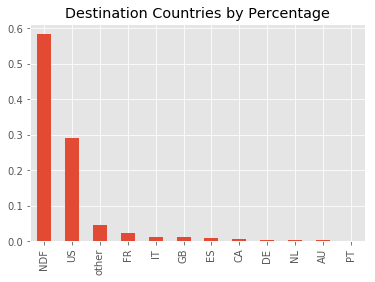

In [50]:
#View country destination
location_percentage = train_users['country_destination'].value_counts()/len(train_users)
location_percentage.plot(kind='bar')
plt.title('Destination Countries by Percentage')
#Over half of the user have non-defined destinations, 30% travels in the US. 
#Therefore by having good prediction on these two we can achieve at least 80% accuracy.

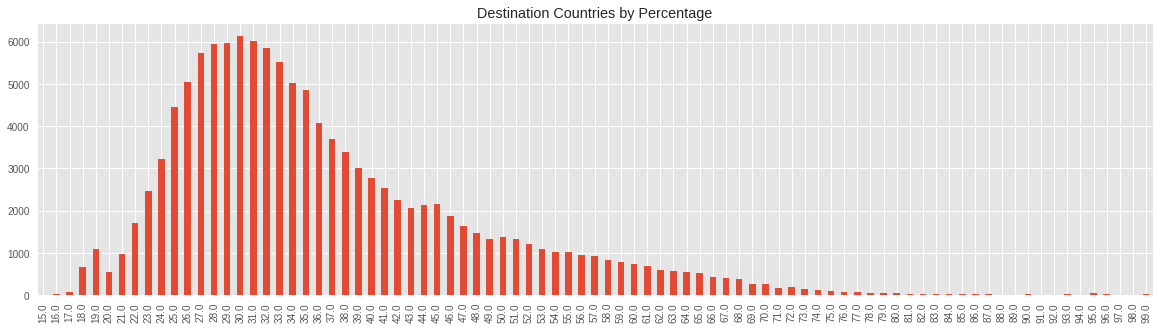

In [115]:
lwr = train_users.age < 100 
upr = train_users.age > 10
#Another thing to look at maybe Countries group by age group
plt.figure(figsize=(20, 5))
age_percentage = train_users.age[lwr & upr].value_counts()
age_percentage.sort_index().plot(kind='bar')
plt.title('Airbnb User Age Dist')
#Majority of users in their late twenties - early thirties

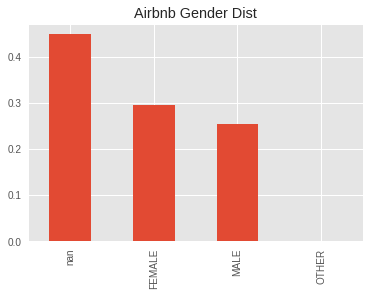

In [120]:
gender_percentage = train_users.gender.value_counts(dropna=False)/len(train_users)
gender_percentage.plot(kind='bar')
plt.title('Airbnb Gender Dist')
#Well balnaced between male and female with female slightly more.

In [4]:
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]

for categorical_feature in categorical_features:
    train_users[categorical_feature] = train_users[categorical_feature].astype('category')

train_users['date_account_created'] = pd.to_datetime(train_users['date_account_created'])
train_users['date_first_booking'] = pd.to_datetime(train_users['date_first_booking'])
train_users['date_first_active'] = pd.to_datetime((train_users.timestamp_first_active // 1000000), format='%Y%m%d')

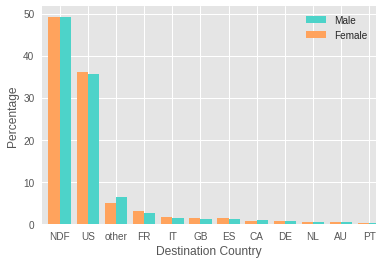

In [122]:
women = sum(train_users['gender'] == 'FEMALE')
men = sum(train_users['gender'] == 'MALE')

female_destinations = train_users.loc[train_users['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = train_users.loc[train_users['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

# Bar width
width = 0.4

male_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=width, color='#FFA35D', position=1, label='Female', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

In [5]:
#For marketing purposes, companies like to see where their users click their links from.
day = []
month = []
year = []
for date in train_users.date_account_created:
    day.append(date.day)
    month.append(date.month)
    year.append(date.year)
train_users['day'] = pd.Series(day)
train_users['month'] = pd.Series(month)
train_users['year'] = pd.Series(year)

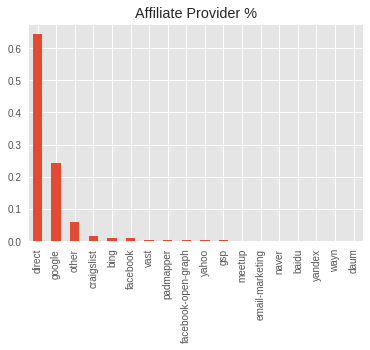

In [200]:
#View country destination
affiliate_percentage = train_users['affiliate_provider'].value_counts()/len(train_users)
affiliate_percentage.plot(kind='bar')
plt.title('Affiliate Provider %')
#Most people sign up directly on airbnb, so web traffic is organic, generated by the company itself rather than serach engines.

In [100]:
grouped = train_users.groupby(['country_destination'])
months = []
counts = []
grp = []
for key, group in grouped:
    grp.append(np.repeat(key, 12))
    months.append(group['month'].value_counts().index.get_values())
    counts.append(group['month'].value_counts().get_values())

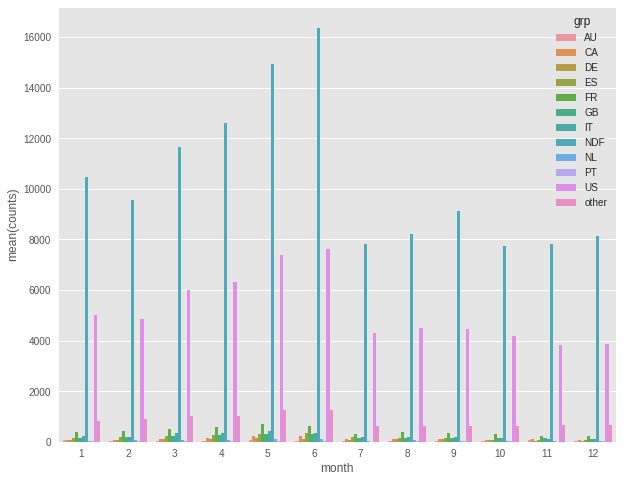

In [101]:
plotData = pd.DataFrame({'month':flatten(months),'counts':flatten(counts),'grp':flatten(grp)})
plt.figure(figsize=(10, 8))
sns.barplot(x="month", y="counts", hue="grp", data=plotData);
#People tend to travel beginning of the year

In [227]:
#Time between first booking and account created
tmp = train_users.date_first_booking - train_users.date_account_created
counts = tmp.value_counts()
days = (counts.index / np.timedelta64(1, 'D')).astype(int)
plotDict =  dict.fromkeys(['Same Day','PriorToCreation','within30Days','between30-60Days',
                          'between60-90Days','between90-180Days','>180Days'], 0)
for day in days:
    if day == 0:
        plotDict['Same Day'] += counts[str(day) + ' days']
    elif day < 0:
        plotDict['PriorToCreation'] += counts[str(day) + ' days']
    elif 0 < day <= 30:
        plotDict['within30Days'] += counts[str(day) + ' days'] 
    elif 30 < day <= 60:
        plotDict['between30-60Days'] += counts[str(day) + ' days'] 
    elif 60 < day <= 90:
        plotDict['between60-90Days'] += counts[str(day) + ' days'] 
    elif 90 < day <= 180:
        plotDict['between90-180Days'] += counts[str(day) + ' days'] 
    elif 180 < day:
        plotDict['>180Days'] += counts[str(day) + ' days'] 
    else:
        plotDict[str(day)] += counts[str(day) + ' days']

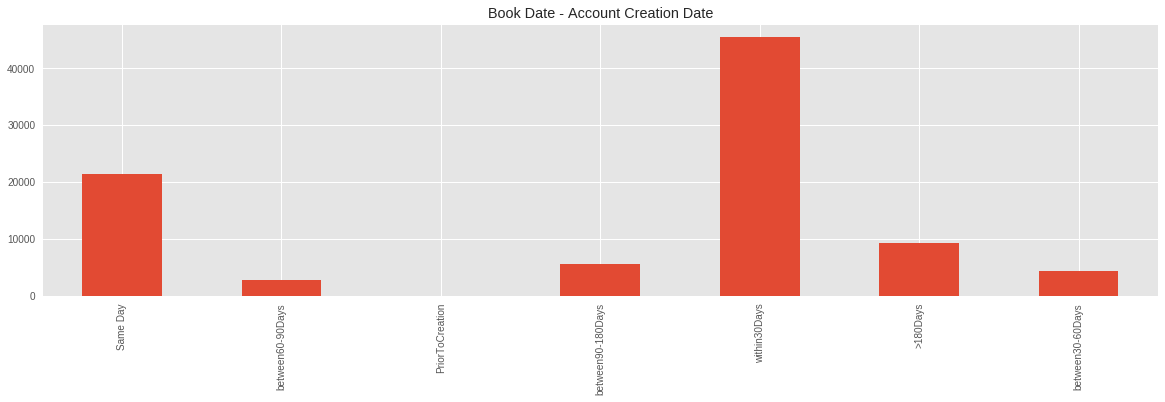

In [229]:
plotData = pd.Series(data = plotDict.values(), index = plotDict.keys())
plt.figure(figsize=(20, 5))
plotData.plot(kind='bar')
plt.title('Book Date - Account Creation Date')
#Most people book  trip within 30 day of account creation or same day. 

In [286]:
top20actions = sessions.action.value_counts()[0:20]
top20actions = sessions[sessions['action'].isin(top20actions.index)]
grouped = top20actions.groupby(['action'])
mediantime= []
grp = []
for key, group in grouped:
    grp.append(key)
    mediantime.append(group['secs_elapsed'].median()/60)

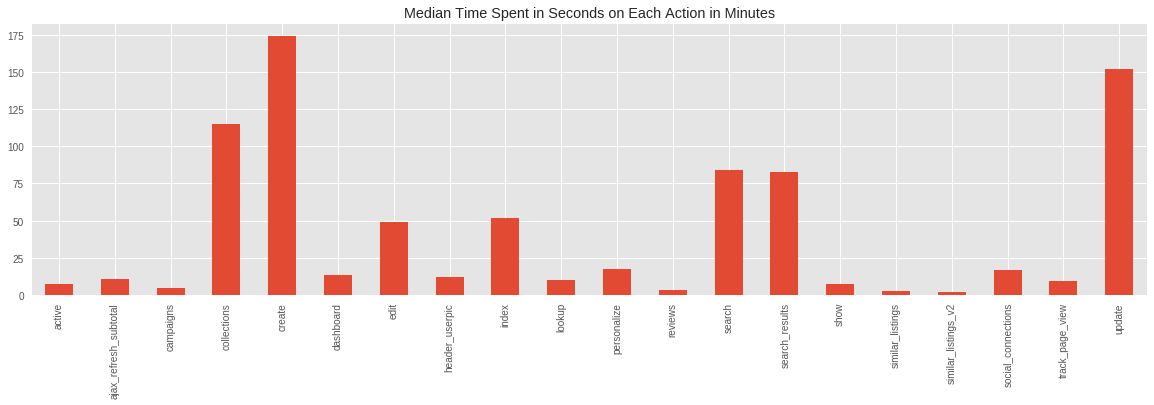

In [289]:
plotData = pd.Series(data = mediantime, index = grp)
plt.figure(figsize=(20, 5))
plotData.plot(kind='bar')
plt.title('Median Time Spent in Seconds on Each Action in Minutes')